# Twitter Sentiment Analysis using Word2vec and Neural Networks 

In [1]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from bs4 import BeautifulSoup
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, concatenate, Activation, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Bidirectional, MaxPooling1D
from keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Introduction

Neural networks are a set of algorithms inspired by how the human brain works and it transcends human ability to work on a large volume of data. The potential of neural networks in achieving high accuracy is nonnegligible. As a sub-field of Natural Language Processing (NLP), sentiment analysis is the process of detecting people's emotions base on one's text. Nowadays, sentiment analysis has become a vital part of the business. For example, companies could immediately identify the customer's attitude towards a product according to what they describe in feedback, to take action instantly.  

The twitter dataset is analyzed in this project. Twitter is one of the most worldwide popular open social networks. As of 2019, twitter boasts more than 330 million monthly active users, and half a billion tweets are sent out each day. For business, twitter is clearly an important source to gain valuable information such as customer feedback. 

Word embeddings technique word2vec and two popular deep learning architectures Convolution Neural Networks (CNN), Long short-term memory (LSTM) are used in twitter text classification task. The aim of the project is to perform a sentiment analysis of tweets using word2vec as well as neural network architectures.

# Data Pre-processing

Due to the massive size of the twitter dataset, uploading the dataset from a local file is extremely time-consuming. Therefore I decide to access the dataset from my own Google Drive, which only takes a few seconds. 

In [2]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/ST449"
os.chdir(path)
os.listdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['training1600000.csv',
 'cleaned_tweets.csv',
 'tweet_model.word2vec',
 'CNN_tweet.01-0.8225.hdf5',
 'CNN_tweet.02-0.8229.hdf5',
 'LSTM_tweet.01-0.8314.hdf5',
 'LSTM_tweet.02-0.8354.hdf5',
 'LSTM_tweet.03-0.8373.hdf5',
 'LSTM_tweet.04-0.8382.hdf5',
 'LSTM_tweet.05-0.8393.hdf5',
 'ST449 project.ipynb']

The dataset I use in this report is sentiment140. It contains 1.6 million tweets extracted using twitter API. Sentiment140 dataset contains 6 attributes:
1. sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. id: the id of the tweet 
3. date: the date of the tweet
4. query: whether there is a query
5. user: the user of the tweet
6. text: the text of the tweet 

However, only sentiment and text in this dataset are related to the aim of my research. Therefore, I will focus on these two fields from now on.

In [0]:
twitterdata = pd.read_csv("training1600000.csv", header=None, encoding='ISO-8859-1', names=["sentiment", "id", "date", "query", "user", "text"])
twitterdata = twitterdata[["sentiment", "text"]] 
twitterdata.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


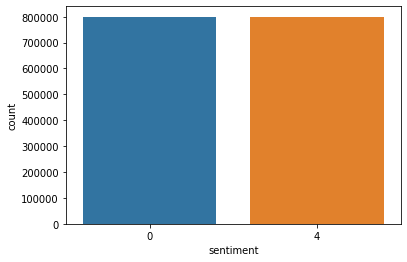

In [0]:
sns.countplot(x = 'sentiment', data = twitterdata)

As shown in the bar plot above, 50% of text data are labeled positive and another half are labeled negative. There is no neutral class. Therefore I decide to use labels 0 and 1 to represent negative tweet and positive tweet respectively. 

In [0]:
twitterdata.sentiment = twitterdata.sentiment.replace({4: 1})

Next, wordcloud visualization for both positive tweets and negative tweets are displayed. As shown in figures below, positive tweets often include words like "awesome", "thanks", "haha", and "hope". Inversely, negative tweets usually include words such as "sorry", "sad" and "work".

(-0.5, 399.5, 199.5, -0.5)

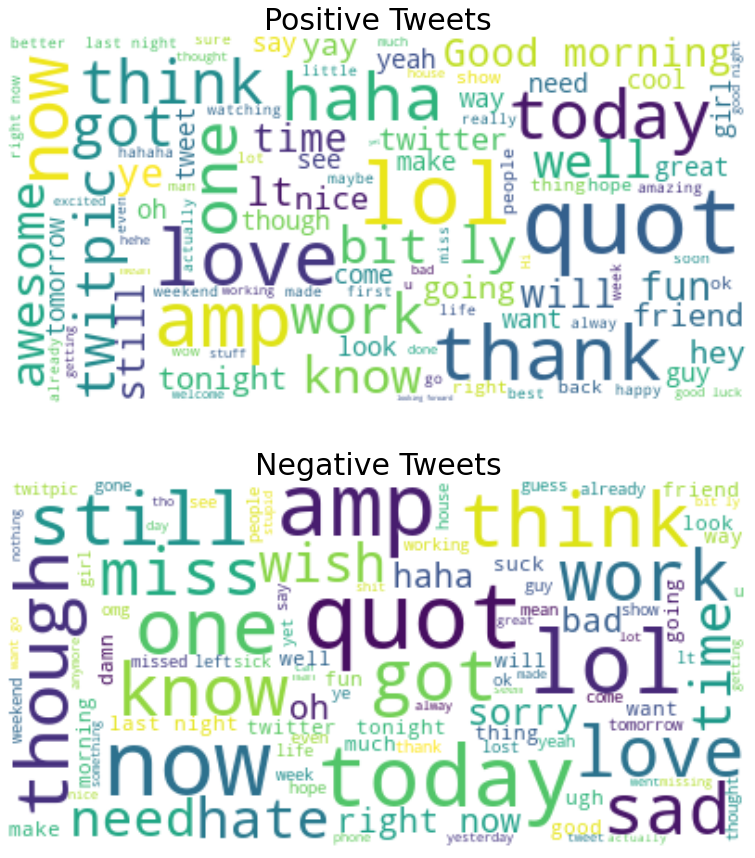

In [0]:
df_neg = twitterdata[twitterdata['sentiment']==0]
df_pos = twitterdata[twitterdata['sentiment']==1]
tweet_pos = " ".join(review for review in df_pos.text)
tweet_neg = " ".join(review for review in df_neg.text)

fig, ax = plt.subplots(2, 1, figsize  = (15,15))
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_neg)

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title('Positive Tweets',fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title('Negative Tweets',fontsize=30)
ax[1].axis('off')

## Data Cleaning



Before doing any further analysis, the text data should be cleaned by the following steps:
1. Decode HTML to general text.
2. Delete the @mention, because this information does not add any value to sentiment analysis.
3. Delete the URL links for the same reason.
4. Remove the BOM. Some of the text contains characters such as "ï»¿" because of UTF-8 BOM.
5. Split negative words into two-part (e.g. can't to can not).
6. Remove punctuations.
7. Turn words into lower cases.
8. Remove stops words that don't have meaning.
9. Stemming - Transforme any form of a word to its root word (e.g. sadness to sad).


The goal of stop words is to remove those meaningless words. However some negative words such as "not", "no" are involved in the list of stop words. These words should be removed from stop words in sentiment analysis, beacuse the meaning of a sentence would be completely changed without them.

In [0]:
negative_words = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not", "needn't":"need not", "she'll": "she will", "he'll":"he will", 
                "we'll":"we will", "i'll":"i will", "they've":"they have", "i'm":"i am"} 
neg_pattern = re.compile(r'\b(' + '|'.join(negative_words.keys()) + r')\b')

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words_add = ["must", "could", "need", "would", "mine"]
stop_words.extend(stop_words_add)
stop_words.remove("not")
stop_words.remove("no")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    text = [word for word in text_tokens if not word in stop_words]
    return text

ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

nltk.download('punkt')
def tweet_clean(text):
  html_clean = BeautifulSoup(text, 'lxml').get_text() 
  tag_clean = re.sub(r'@[A-Za-z0-9]+', '', html_clean) 
  url_clean = re.sub(r'https?://[A-Za-z0-9./]+', '', tag_clean) 
  url_clean = re.sub(r'www.[^ ]+', '', url_clean)
  if "\xef\xbf\xbd" in url_clean:
    utf_bom = url_clean.replace(u"\xef\xbf\xbd", "?")
  else:
    utf_bom = url_clean
  lower_case = utf_bom.lower()
  negative_clean = neg_pattern.sub(lambda x: negative_words[x.group()], lower_case)
  stopwards_clean = remove_stopwords(negative_clean)  
  stem_clean = stemming(stopwards_clean) 
  tweet_clean = (" ".join(stem_clean)).strip() 
  tweet_clean = remove_punct(tweet_clean)
  tweet_clean = " ".join(tweet_clean.split())
  return tweet_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
nums = [0,1600000]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%100000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                   
    clean_tweet_texts.append(tweet_clean(twitterdata['text'][i])) 

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed


The data cleaning process takes a significant amount of time. In order to get access to the cleaned tweets quickly, I save the cleaned data file into my Google Drive and read it without redoing the cleaning process next time.  

In [0]:
#save cleaned data
clean_df = pd.DataFrame({'text': clean_tweet_texts})
clean_df['target'] = twitterdata.sentiment
clean_df.to_csv('cleaned_tweets.csv',encoding='utf-8')
!cp cleaned_tweets.csv "/content/drive/My Drive/ST449

In [0]:
#read clean data
clean_tweet = pd.read_csv('cleaned_tweets.csv', index_col=0)
clean_tweet.dropna(inplace=True)
clean_tweet.reset_index(drop=True,inplace=True)
clean_tweet.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


## Words Encoding (Word2Vec Model)

The neural network does not understand the text, text needs to be converted into a numerical value to be fed into your models. Word2vec is a two-layer neural net that produces word embedding by training words against their neighbor words in the input corpus.



Firstly, I separate the dataset into three parts: training data(90%), validation data(5%), and testing data(5%). Because of the significant twitter dataset, 5% of the whole dataset contains 80,000 tweets, which is large enough for testing.

In [0]:
xs = clean_tweet.text
ys = clean_tweet.target
seed = 1
x_train, x_valid_test, y_train, y_valid_test = train_test_split(xs, ys, test_size=0.1, random_state=seed)
x_validation, x_test, y_validation, y_test = train_test_split(x_valid_test, y_valid_test, test_size=0.5, random_state=seed)

In [0]:
def label_tweets(tweets, label_type):
    labelized_tweets = []
    for i, tweet in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type, i)
        labelized_tweets.append(TaggedDocument(tweet.split(), [label]))
    return labelized_tweets   

x_train_labelled = label_tweets(x_train, 'TRAIN')
x_all_labelled = label_tweets(xs, 'all')

1436869it [00:09, 157269.12it/s]
1596522it [00:08, 181376.80it/s]


In [0]:
x_all_labelled[0]

TaggedDocument(words=['awww', 'that', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it'], tags=['all_0'])

Word2Vec consists of two learning models, which are continuous bag of words (CBOW) and skip-gram. The biggest difference between these two models is CBOW tends to predict the probability of a word by the context, whereas the skip-gram model is designed to predict the context by word. The advantage of CBOW is that it is faster to train and it has better accuracy for frequent words. There are pre-trained word2vec word embedding models from Google and Stanford. However, training own word vectors may be the best approach in this case, because sentiment104 has a sufficiently large corpus. CBOW model with learning rate 0.065 and 30 epochs are used to train the twitter dataset.

In [0]:
w2v_model = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=3, workers=2, alpha=0.065, min_alpha=0.0065)
w2v_model.build_vocab([x.words for x in tqdm(x_all_labelled)])
w2v_model.train(utils.shuffle([x.words for x in tqdm(x_all_labelled)]), total_examples=len(x_all_labelled), epochs=30, report_delay=1)
w2v_model.save('tweet_model.word2vec')

100%|██████████| 1596522/1596522 [00:00<00:00, 3092992.86it/s]


(444537381, 563712720)

In [0]:
#save word2vec model
word2vec_model = KeyedVectors.load('tweet_model.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embedding_vectors = {}
for w in word2vec_model.wv.vocab.keys():
    embedding_vectors[w] = word2vec_model.wv[w]
print(str(len(embedding_vectors)) + " words in total")

76804 words in total


Before this, word2vec are used to “vectorizing” each word in tweets. In order to do sentiment analysis for tweets, each tweet needs to be turned into vectors as well. To do this, I combine the vector representation of each word and get a new vector representation that matches the origin tweet. In this way, whole tweets convert into computer-readable numerical numbers.  

In [0]:
tokenizer = Tokenizer(num_words=100000) #split sentence into words
tokenizer.fit_on_texts(x_train)
reviews_words = tokenizer.texts_to_sequences(x_train) #sequential representation of each sentence

## Padding Sequences

Now each tweet converted into a corresponding matrix with different lengths. However, the neural network model requires the input data has the same dimensionality. To solve this problem, I  pad the input by assuming a maximum length of words for each sentence, all tweets will transform to the maximum length. For inputs that have a shorter length, zero pads the rest. And for those sentences longer than the maximum length, the extra words will be truncated.




In [0]:
length = []
for x in x_train[:100]:
    length.append(len(x.split()))
max(length)

26

In this case, the maximum number of words within a tweet in the training dataset is 26. Therefore I let the maximum length to be slightly longer than that, let it equals to 35. 

In [0]:
max_length = 35
x_train_seq = pad_sequences(reviews_words, maxlen=max_length)
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1542,     5,   442,  1617,    28,   231,
         1546,    10,    37, 72175,   123,    16,    27,    29],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    67,  3991,   126,   177,  4107,  1845],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   374, 11829,    38,  1109,    10,    24,   541],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   

In [0]:
#pad validation data and testing data as well
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=max_length)
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

After the sentences are transformed into sequences, each word in a tweet is represented by a numerical number which indicates the place it is stored in tokenizer. Next, I generate a matrix that contains frequent words in the training data and the index of word in tokenizer corresponds to the word vector that is generated from word2vec.   

In [0]:
num_words = len(embedding_vectors)+1 
embedding_matrix = np.zeros((num_words, 100))
for w, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_vectors.get(w)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convolutional Neural Network(CNN)

## CNN Molde

CNN has a convolutional layer to extract texts data features piece by piece and to consider the relationship among these features. The word vectors that represent the tweets are the input of the CNN model. This is 1D CNN because the fitter's column width has the length as the data column width.

The structure of this CNN model is inspired by a paper, ["A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"](https://arxiv.org/pdf/1510.03820.pdf). In the embedding layer, I pass the pre-defined embedding "embedding_matrix". I apply three 1D CNN layers in this model. Usually, In order to find the higher dimensionality, the number of filters in the following layer is multiply of filters number in the previous layer. Therefore, I set the filter sizes 32, 64, 128, and kernel sizes 2, 3, 4 respectively. Global Max Pooling layers are followed by every 1D CNN layer, the pooling layer extracts the maximum value from each filter. Then I concatenate three max pooled layers before a fully connected layer. At last, a dropout layer with a drop out rate 0.2 and another fully connected layer are added just before the output layer. 



In [0]:
filters_sizes = [32, 64, 128]
kernel_sizes = [2,3,4]
dropout_rate = 0.2

def sentiment_CNN(embedding_matrix, filters=filters_sizes, kernel_sizes=kernel_sizes, dropout_rate=dropout_rate): #pool_size=pool_size
  tweet_input = Input(shape=(max_length,), dtype='int32') #Input layer
  tweet_embedding = Embedding(input_dim=(num_words), output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=True)(tweet_input) #Embedding layer
  tweet_embedding = Dropout(rate=dropout_rate)(tweet_embedding) #Dropout layer

  conv1 = Conv1D(filters=filters[0], kernel_size=kernel_sizes[0], padding="valid", activation="relu", strides=1)(tweet_embedding)
  conv1 = GlobalMaxPooling1D()(conv1)
  conv2 = Conv1D(filters=filters[1], kernel_size=kernel_sizes[1], padding="valid", activation="relu", strides=1)(tweet_embedding)
  conv2 = GlobalMaxPooling1D()(conv2)
  conv3 = Conv1D(filters=filters[2], kernel_size=kernel_sizes[2], padding="valid", activation="relu", strides=1)(tweet_embedding)
  conv3 = GlobalMaxPooling1D()(conv3)
  conv_merged = concatenate([conv1, conv2, conv3], axis=1)
  
  conv_merged = Dense(128, activation="relu")(conv_merged) #256
  conv_merged = Dropout(rate = dropout_rate)(conv_merged)
  model_output = Dense(1, activation="sigmoid")(conv_merged)

  model = Model(inputs=[tweet_input], outputs=[model_output])
  return model

In [0]:
model = sentiment_CNN(embedding_matrix)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 100)      7680500     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 35, 100)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 32)       6432        dropout_1[0][0]                  
____________________________________________________________________________________________

In [0]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
filepath="CNN_tweet.{epoch:02d}-{val_accuracy:.4f}.hdf5" #model checkpoints will be saved with the epoch number and the validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=32, epochs=5,validation_data=(x_val_seq, y_validation), callbacks = [checkpoint]) #validation loss&accuracy

Train on 1436869 samples, validate on 79826 samples
Epoch 1/5
1436869/1436869 [==============================] - 566s 394us/step - loss: 0.2708 - accuracy: 0.8885 - val_loss: 0.4497 - val_accuracy: 0.8225

Epoch 00001: val_accuracy improved from -inf to 0.82251, saving model to CNN_tweet.01-0.8225.hdf5
Epoch 2/5
1436869/1436869 [==============================] - 572s 398us/step - loss: 0.2661 - accuracy: 0.8908 - val_loss: 0.4814 - val_accuracy: 0.8229

Epoch 00002: val_accuracy improved from 0.82251 to 0.82285, saving model to CNN_tweet.02-0.8229.hdf5
Epoch 3/5
1436869/1436869 [==============================] - 568s 395us/step - loss: 0.2623 - accuracy: 0.8925 - val_loss: 0.4866 - val_accuracy: 0.8228

Epoch 00003: val_accuracy did not improve from 0.82285
Epoch 4/5
1436869/1436869 [==============================] - 567s 394us/step - loss: 0.2584 - accuracy: 0.8945 - val_loss: 0.4890 - val_accuracy: 0.8198

Epoch 00004: val_accuracy did not improve from 0.82285
Epoch 5/5
1436869/14368

The best model is the second one with the highest validation accuracy 0.8229. I save the best model for model evaluation with test data.

In [0]:
CNN_model = load_model("CNN_tweet.02-0.8229.hdf5") 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## CNN Evaluation

In [0]:
CNN_model.evaluate(x=x_test_seq, y=y_test)

79827/79827 [==============================] - 4s 51us/step


[0.4787341555235884, 0.8243200778961182]

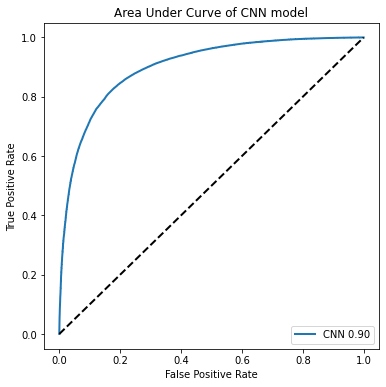

In [0]:
cnn_predicted = CNN_model.predict(x_test_seq)
fpr, tpr, __ = roc_curve(y_test, cnn_predicted)
cnn_auc = auc(fpr, tpr) #area under curve  
cnn_auc = ("%.2f" % cnn_auc)
#plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='CNN '+ str(cnn_auc), linewidth=2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('Area Under Curve of CNN model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

I fit the best CNN model in testing data, the loss value is 0.4787 and accuracy is 0.8243.

# Long Short-Term Memory (LSTM)

## LSTM Model

LSTM is a recurrent neural network (RNN) architecture designed to deal with sequential data by sharing their internal weights across the sequence. It takes two sources of input, the current one and the memory from the previous word, and combine them to make decisions. This type of architecture is more suitable for the twitter dataset since each word in a sentence has meaning based on the previous and upcoming words. In the LSTM model, the embedding matrix trained by word2vec is passed into the embedding model. A normal LSTM only reads a sentence from one direction. To solve this problem, bidirectional LSTM are introduced. One bidirectional LSTM layers with dropout rate 0.2 and recurrent dropout rate 0.2 are added to this model. Finally, a fully connected layer with a sigmoid function is applied. 



In [0]:
def sentiment_LSTM(embedding_matrix):
  tweet_input = Input(shape=(max_length,), dtype='int32') #Input layer
  tweet_embedding = Embedding(input_dim=(num_words), output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=True)(tweet_input) #Embedding layer
  biLSTM_1 = Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(tweet_embedding)
  #biLSTM_2 = Bidirectional(LSTM(100, return_sequences=False))(biLSTM_1)
  dropout_2=Dropout(0.5)(biLSTM_1)
  dense_2 = Dense(1, activation='sigmoid')(dropout_2)
  model = Model(inputs=tweet_input, outputs=dense_2)
  return model

I tried a model with two bidirectional LSTM layers which take twice the amount of time as the "sentiment_LSTM" model. However, the accuracy of these two models is similar. In this case, I choose the one with fewer layers  to reduce the computational expense.

In [0]:
from keras.layers.normalization import BatchNormalization
model = sentiment_LSTM(embedding_matrix)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 35, 100)           7680500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,915,253
Trainable params: 7,915,253
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

filepath="LSTM_tweet.{epoch:02d}-{val_acc:.4f}.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(x_train_seq, y_train, batch_size=128, epochs=7,validation_data=(x_val_seq, y_validation), callbacks = [checkpoint]) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1436869 samples, validate on 79826 samples
Epoch 1/7
1436869/1436869 [==============================] - 2610s 2ms/step - loss: 0.4129 - acc: 0.8111 - val_loss: 0.3769 - val_acc: 0.8314

Epoch 00001: val_acc improved from -inf to 0.83141, saving model to LSTM_tweet.01-0.8314.hdf5
Epoch 2/7
1436869/1436869 [==============================] - 2621s 2ms/step - loss: 0.3736 - acc: 0.8334 - val_loss: 0.3680 - val_acc: 0.8354

Epoch 00002: val_acc improved from 0.83141 to 0.83544, saving model to LSTM_tweet.02-0.8354.hdf5
Epoch 3/7
1436869/1436869 [==============================] - 2614s 2ms/step - loss: 0.3579 - acc: 0.8418 - val_loss: 0.3667 - val_acc: 0.8373

Epoch 00003: val_acc improved from 0.83544 to 0.83735, saving model to LSTM_tweet.03-0.8373.hdf5
Epoch 4/7
1436869/1436869 [==============================] - 2595s 2ms/step - loss: 0.3466 - acc: 0.8477 - val_loss: 0.3693 - val_acc: 0.8382

Epoch 00004: val_acc improved from 0.83735 to 0.83825, saving model to LSTM_tweet.04-0.8

In [0]:
from keras.models import load_model
LSTM_model = load_model("LSTM_tweet.05-0.8393.hdf5")  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
LSTM_model.evaluate(x=x_test_seq, y=y_test)

79827/79827 [==============================] - 46s 577us/step


[0.36326696018681837, 0.8409435153007507]

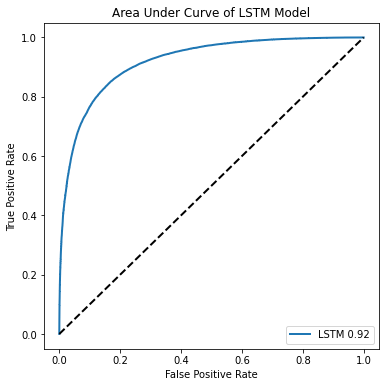

In [0]:
from sklearn.metrics import roc_curve, auc
LSTM_predicted = LSTM_model.predict(x_test_seq)
fpr, tpr, __ = roc_curve(y_test, LSTM_predicted)
LSTM_auc = auc(fpr, tpr) #area under curve  
LSTM_auc = ("%.2f" % LSTM_auc)
#plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='LSTM '+ str(LSTM_auc), linewidth=2)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('Area Under Curve of LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Conclusion

In this project, the twitter dataset is analyzed using word2vec which creates word embeddings, and two neural networks CNN and LSTM. The neural network models identify the emotion of a person based on the tweet they send. As shown in the table below, the LSTM model has a better performance than the CNN model. The LSTM model has a lower test loss and a higher value in test accuracy as well as AUC score.
>  Moldes/Model Evaluation| test loss | test accuracy | AUC score
>--- | --- | --- | --- 
>CNN model | 0.479 | 0.824 | 0.90
>LSTM model | 0.363 | 0.841 | 0.92



# Reference:

[Twitter information](https://www.oberlo.com/blog/twitter-statistics)

["Word Embeddings for Information Extraction from Tweets"](http://ceur-ws.org/Vol-1737/T2-4.pdf)


["BB twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs
and LSTMs"](https://www.aclweb.org/anthology/S17-2094.pdf)


["UNIMELB at SemEval-2016 Tasks 4A and 4B: An Ensemble of
Neural Networks and a Word2Vec Based Model for Sentiment
Classification"](https://www.aclweb.org/anthology/S16-1027.pdf)
